# Imports

In [1]:
# System
import sys

# Plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt

# math and array tools 
import numpy as np
import pandas as pd
from scipy import interpolate
from itertools import permutations

# Access local directories
import os, glob

# Timing
import time as t

# Density Profiles

## Global Varibles

In [2]:
# unit conversions
hz_to_invpc = 1.029e8
s_to_pc = 9.716e-9
m_to_pc = 3.241e-17
solar_mass_to_pc = 4.8e-14
g_cm3_to_invpc2 = 7.072e8
year_to_pc = 0.3064

## Generic Density Distribution

In [3]:
scale = {'a':0.01, 'rho0':0.3}
NFWparams = {'alpha':1,'beta':3,'gamma':1}
Hernquistparams = {'alpha':1,'beta':4,'gamma':1}

In [4]:
def rho_DM_general(r, **kwargs):
    a, rho0 = kwargs['a'], kwargs['rho0']
    alpha, beta, gamma = kwargs['alpha'], kwargs['beta'], kwargs['gamma']
    # x is dimensionless
    x = r/a
    
    rho = rho0*(x**(-gamma))*(1+(x**alpha))**((gamma-beta)/alpha)
    
    # convert to pc^-2
#     rho *= 1.264e-15 #[GeV/cm3 to pc-2]
    return rho

## Effective Scaling GR Density

In [5]:
scaleparameters={
    'a':20.0, #[kpc]
    'rho0':0.3, #[GeV/cm^3]
    'Mbh':1e6 #[Msol]    
}
NFWparameters={
    'alpha':0.331,
    'beta':-1.66,
    'gamma':0.32,
    'delta':-0.000282
}
Hernparameters={
    'alpha':0.335,
    'beta':-1.67,
    'gamma':0.31,
    'delta':-0.025
}
NFWfit_newton={
    'eta':2,
    'A':1.60,
    'w':2.18,
    'q':1.98
}
NFWfit_rel={
    'eta':1,
    'A':6.42,
    'w':1.82,
    'q':1.91
}
Hernfit_newton={
    'eta':2,
    'A':4.87,
    'w':2.22,
    'q':1.93
}
Hernfit_rel={
    'eta':1,
    'A':7.90,
    'w':1.83,
    'q':1.90
}

In [6]:
#takes inputs as Mbh in solar mass, r in kpc, A in Msol^-2 and outputs in GeV/cm^3

def rho_effective(r, **kwargs):
    # scale params
    rho0, Mbh, a = kwargs['rho0'], kwargs['Mbh'], kwargs['a']
    # profile params
    alpha, beta, gamma, delta = kwargs['alpha'], kwargs['beta'], kwargs['gamma'], kwargs['delta']
    # fit params 
    A, w, q, eta= kwargs['A'], kwargs['w'], kwargs['q'], kwargs['eta']
   
    # convert units so rho_bar has units 1/pc^2 and x_tilde is unitless
    r *= 1e3 #[kpc to pc]
    
    Mbh1 = Mbh  #Preserve an blackhole mass in solar masses for future reference in rho
    
    Mbh *= 4.8e-14 #[Msol to pc]
    A *= (10**-43) * (4.367e26) #[Msol^-2 to pc^-2: 1/2.29e-27]
    x_tilde = r/Mbh
    
    rho_bar = A*((1-(4*eta / x_tilde))**w)*(((4.17*10**11)/x_tilde)**q)
    
    rho = rho_bar*(10**delta)*((rho0/0.3)**alpha)*((Mbh1/1e6)**beta)*((a/20)**gamma)
    
    # convert back to GeV/cm^3 from 1/pc^2
#     rho *= 1.264e15 
    rho*=7.934e14

    return rho

In [7]:
# rho effective takes a dictionary with scale params, profile params and fit params
rho_NFW_Newton_params = {**scaleparameters, **NFWparameters, **NFWfit_newton}

rho_effective(0.1, **rho_NFW_Newton_params)

1996.3671083813435

In [12]:
import halo
import merger_system as ms

ModuleNotFoundError: No module named 'halo'

# Plotting and tests

## Comparing NFW and Hernquist

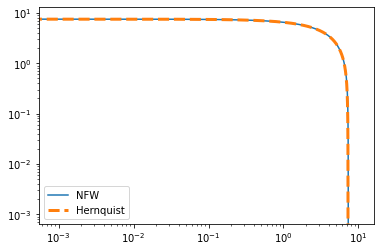

In [15]:
# r_list = np.geomspace(1e-6,100,100)

r_list = np.geomspace(1e-11,1,10000)


NFWparams = {**scale,**NFWparams}
Hernparams = {**scale,**Hernquistparams}

rhoNFW = np.array([[r, rho_DM_general(r, **NFWparams)] for r in r_list])
rhoHern = np.array([[r, rho_DM_general(r, **Hernparams)] for r in r_list])

plt.loglog(np.log10(rhoNFW[:,0]/(9.608e-11)),np.log10(rhoNFW[:,1]), label='NFW')
plt.loglog(np.log10(rhoHern[:,0]/(9.608e-11)),np.log10(rhoHern[:,1]),'--', label='Hernquist', linewidth = 3)
# plt.xscale('log')
plt.legend()

## Plotting Effective Scaling Density

## Figure 1 plot a

<ipython-input-14-1963d607b900>:20: RuntimeWarning: invalid value encountered in double_scalars
  rho_bar = A*((1-(4*eta / x_tilde))**w)*(((4.17*10**11)/x_tilde)**q)


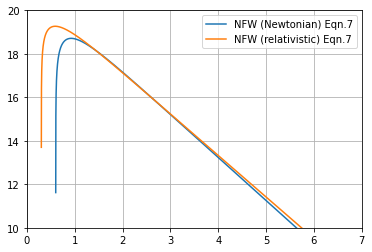

In [16]:

# r is entered in kpc
r_list = np.geomspace(1e-11,1e3,100000)

rho_NFW_Newton_params = {**scaleparameters, **NFWparameters, **NFWfit_newton}
rho_NFW_rel_params = {**scaleparameters, **NFWparameters, **NFWfit_rel}

#take log after 
rhoNFW_Newton = np.array([[r, rho_effective(r, **rho_NFW_Newton_params)] for r in r_list])
rhoNFW_rel = np.array([[r, rho_effective(r, **rho_NFW_rel_params)] for r in r_list])


plt.plot(np.log10(rhoNFW_Newton[:,0]/(9.608e-11)),np.log10(rhoNFW_Newton[:,1]), label='NFW (Newtonian) Eqn.7')
plt.plot(np.log10(rhoNFW_rel[:,0]/(9.608e-11)),np.log10(rhoNFW_rel[:,1]), label='NFW (relativistic) Eqn.7')

# plt.loglog(rhoNFW[:,0],rhoNFW[:,1], label='NFW Eqn.1')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(0,7)
plt.ylim(10,20)
plt.xlim(0,7)
plt.grid()
plt.legend()

## Figure 1 plot b

<ipython-input-14-1963d607b900>:20: RuntimeWarning: invalid value encountered in double_scalars
  rho_bar = A*((1-(4*eta / x_tilde))**w)*(((4.17*10**11)/x_tilde)**q)


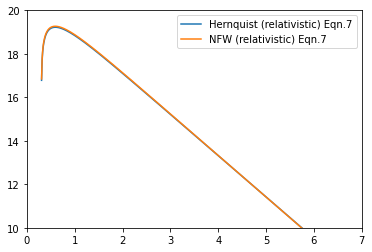

In [17]:
r_list = np.geomspace(1e-11,1,1000)
#r_list = np.log10(r_list/(9.608e-11))

rho_NFW_Hernquist_params = {**scaleparameters, **Hernparameters, **Hernfit_rel}
rho_NFW_rel_params = {**scaleparameters, **NFWparameters, **NFWfit_rel}

#take log after 
rhoHern_rel = np.array([[r, rho_effective(r, **rho_NFW_Hernquist_params)] for r in r_list])
rhoNFW_rel = np.array([[r, rho_effective(r, **rho_NFW_rel_params)] for r in r_list])


plt.plot(np.log10(rhoHern_rel[:,0]/(9.608e-11)),np.log10(rhoHern_rel[:,1]), label='Hernquist (relativistic) Eqn.7')
plt.plot(np.log10(rhoNFW_rel[:,0]/(9.608e-11)),np.log10(rhoNFW_rel[:,1]), label='NFW (relativistic) Eqn.7')
#plt.loglog(rhoNFW[:,0],rhoNFW[:,1], label='NFW Eqn.1')
# plt.yscale('log')
#plt.xscale('log')
plt.xlim(0,7)
plt.ylim(10,20)
plt.legend()

## Attempting to recreate Figure 1 from Sadeghian:
https://arxiv.org/pdf/1305.2619.pdf

## Eda paper mini-spike profile:

$\rho_{DM}(r)  =\begin{cases}
\rho_{\text{spike}}(r), & r_{\text{min}}\le r \le r_{\text{sp}}\\
\rho_{\text{NFW}} & r_{\text{sp}}<r
\end{cases}
$

with

$\rho_{\text {spike }}(r)=\rho_{\mathrm{sp}}\left(\frac{r_{\mathrm{sp}}}{r}\right)^{\alpha}$

$\alpha=\frac{9-2 \alpha_{\text {ini }}}{4-\alpha_{\text {ini }}}$

In [39]:
#takes input in pc units and outputs in pc units

def Spike_Halo(r, rho_spike, r_spike, alpha, r_min=0):   # Spike Model
    """
    Defining the Halo Model from Eda paper [https://arxiv.org/abs/1408.3534]
    
    The density is given by:
        rho (r) = rho_spike*(r_spike/r)^(alpha)
    
    Parameters:
        rho_spike : float
            The density parameter of the spike profile
        r_spike : float
            The scale radius of the spike profile
        alpha : float
            The power-law index of the spike profile, with condition 0 < alpha < 3
    """
    return  (rho_spike * (r_spike / r)**alpha )


#### Same rho_effective function as before but now takes r as input in pc and not kpc (still outputs in 1/pc^2)

In [52]:
#takes inputs as Mbh in solar mass, r in pc, A in Msol^-2 and outputs in 1/pc^2

def rho_effective(r, **kwargs):
    # scale params
    rho0, Mbh, a = kwargs['rho0'], kwargs['Mbh'], kwargs['a']
    # profile params
    alpha, beta, gamma, delta = kwargs['alpha'], kwargs['beta'], kwargs['gamma'], kwargs['delta']
    # fit params 
    A, w, q, eta= kwargs['A'], kwargs['w'], kwargs['q'], kwargs['eta']
   
    # convert units so rho_bar has units 1/pc^2 and x_tilde is unitless
    #r *= 1e3 #[kpc to pc]
    
    Mbh1 = Mbh  #Preserve an blackhole mass in solar masses for future reference in rho
    
    Mbh *= 4.8e-14 #[Msol to pc]
    A *= (10**-43) * (4.367e26) #[Msol^-2 to pc^-2: 1/2.29e-27]
    x_tilde = r/Mbh
    
    rho_bar = A*((1-(4*eta / x_tilde))**w)*(((4.17*10**11)/x_tilde)**q)
    
    rho = rho_bar*(10**delta)*((rho0/0.3)**alpha)*((Mbh1/1e6)**beta)*((a/20)**gamma)
    
    # convert back to GeV/cm^3 from 1/pc^2
#     rho *= 1.264e15 
    rho*=7.934e14

    return rho

Note that an NFW profile has the form:

$\rho(r)= \rho_{s}(r/r_{s})^{-1}\left(1+(r/r_{s})^{1}\right)^{-2}$

For our system, this is given by:

$\rho_{s} = 3.8 \times 10^{-22} \: \text{g/cm}^3$

$r_s = 23.1 \text{pc}$

According to table 1 in https://arxiv.org/pdf/1408.3534.pdf. 

Comparing with the Speeney paper of the general profile:

$\rho(r)=\rho_{0}(r / a)^{-\gamma}\left(1+(r / a)^{\alpha}\right)^{(\gamma-\beta) / \alpha}$

It implies to get a fitting NFW profile for our system we would need:

$\rho_{0} = 3.8 \times 10^{-22} \: \text{g/cm}^3$

$a = 23.1 \text{pc}$

$\alpha = 1, \: \beta = 3, \: \gamma =1$

In [9]:
rho0 = 3.8*1e-22 #[g/cm^3] from eda paper
rho0 *= 5.62*1e23 #[g/cm^3 to GeV/cm^3]
m1 = 4.8e-11    #mass of the Bh in pc (1000 solar masses)
a = 23.1 #scaling radius from eda in pc
a *= 1e-3 # pc to kpc

#--------------------Halo Parameters from Eda paper in pc natural units -----------------------------
rho_spike = 1.0848e-11               # [226.*solar_mass_to_pc]
alpha_spike = 7/3
r_spike = 0.54


# parameters a, rho0, and Mbh from Eda paper in pc, GeV/cm^2, and solar mass respectively.
scaleparameters={
    'a':a,     #  23.1 but in kpc         
    'rho0':rho0, #3.8e-22 g/cm3 but in GeV/cm3 from eda
    'Mbh':1e3   # m1 but in [Msol]   
}


### Computing the relativistic profile in pc

In [10]:
rho_NFW_rel_params = {**scaleparameters, **NFWparameters, **NFWfit_rel}

r_list = np.linspace(6*m1,100*m1,1000)  #r from 6Gm to 100Gm in pc

rhoNFW_rel = np.array([[r, rho_effective(r, **rho_NFW_rel_params)] for r in r_list])

### Computing the Spiked profile in pc

In [11]:
spiked_rho = Spike_Halo(r_list, rho_spike, r_spike, alpha_spike, r_min=0)

NameError: name 'Spike_Halo' is not defined

### Plotting the region from 6GM (r_isco) to 100 GM (initial parameters of our evolution

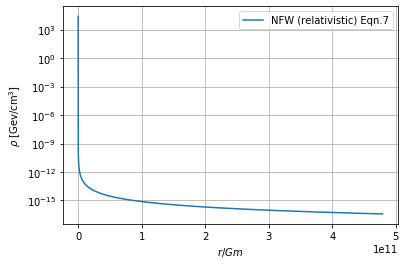

In [17]:
plt.plot(rhoNFW_rel[:,0]/m1  ,rhoNFW_rel[:,1] /(7.934e14), label='NFW (relativistic) Eqn.7')
#plt.plot(r_list/m1   ,spiked_rho / (7.934e14) , label='Spiked Profile')
plt.grid()
plt.xlabel('$ r/Gm $')
plt.ylabel('$ \\rho $ [Gev/cm$^3$]' )
plt.legend()
plt.yscale('log')

### Plotting a larger range 

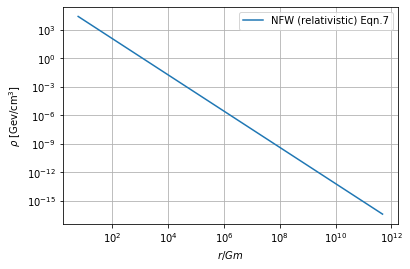

In [16]:

r_list = np.geomspace(6*m1,23,1000) #r from 6Gm to 23 pc  (where the spike transforms to an NFW profile)
 
rhoNFW_rel = np.array([[r, rho_effective(r, **rho_NFW_rel_params)] for r in r_list])
#spiked_rho = Spike_Halo(r_list, rho_spike, r_spike, alpha_spike, r_min=0)



plt.plot(rhoNFW_rel[:,0]/m1  ,rhoNFW_rel[:,1] /(7.934e14), label='NFW (relativistic) Eqn.7')
#plt.plot(r_list/m1   ,spiked_rho / (7.934e14) , label='Spiked Profile')
plt.grid()
plt.xlabel('$ r/Gm $')
plt.ylabel('$ \\rho $ [Gev/cm$^3$]' )
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [ ]:
m_bh = m1
r_s = 23.1
rho_s = 3.8e-22 * ms.g_cm3_to_invpc2
r_schwarzschild = 2.*m_bh

# spike properties
r_sp = 0.54
rho_sp = 226 * ms.solar_mass_to_pc
alpha=7/3
r_grid = np.geomspace( r_schwarzschild, 100*r_s, 1000)

nfwprofile = halo.SpikedNFW(rho_s, r_s, r_sp, alpha)
def rho(r):
    return nfwprofile.density(r)

In [ ]:
function rho_effective(r, Mbh)
    # scale params

    a = 23.1  #[pc] from eda paper
    rho0 = 3.8*1e-22 #[g/cm^3] from eda paper
    rho0 *= 5.60958*1e+23 #[g/cm^3 to GeV/cm^3]


    # profile params
    alpha = 0.331
    beta = -1.66
    gamma = 0.32
    delta = -0.000282
    
    # fit params 
    eta = 1
    A = 6.42
    w = 1.82
    q = 1.91

    # convert units so rho_bar has units 1/pc^2 and x_tilde is unitless
    #r *= 1e3 #[kpc to pc]
    Mbh1 = Mbh / (4.8e-14) #[pc to Msol]
    A *= (10^-43) * (4.367e26) #[Msol^-2 to pc^-2: 1/2.29e-27]
    x_tilde = r./Mbh
    
    rho_bar = A.*((1-( 4. * eta ./ x_tilde)).^w).*(((4.17 * 10^11)./x_tilde).^q)
    
    rho = rho_bar.*(10^delta).*((rho0/0.3)^alpha).*((Mbh1/1e6)^beta).*((a/20)^gamma)
    
    # convert back to GeV/cm^3 from 1/pc^2
#     rho *= 1.264e15
    return rho
end

## Testing the r grid

In [183]:
r_list = np.geomspace(1e-10,1,10000) #kpc
Rs = 9.608e-11 #kpc
print(np.log(r_list/Rs))

[ 0.03998901  0.04229182  0.04459464 ... 23.06123431 23.06353712
 23.06583994]


In [203]:
arr = [[i,r] for i,r in (enumerate(np.log(r_list/Rs)))]
print(arr.flatten())
# plt.plot()

AttributeError: 'list' object has no attribute 'flatten'

In [197]:
list(enumerate(np.log(r_list/Rs)))

In [206]:
arr[:,0]

TypeError: list indices must be integers or slices, not tuple